# [Refine Use of Explored NTD Variables #1646](https://github.com/cal-itp/data-analyses/issues/1646)

Question or Goal:

1. Mode & Service: We previously used these to define the grain of the data. These should be used for classifying/model-fitting.
    - There are many modes: Can we group modes so there are fewer of them (e.g. fixed-guideway vs not)? Too many dummy variables for a category leads to overfitting/too many clusters.
    - What's the best way to use Service? Is it as a dummy variable? Is it numeric "proportion of service(VRH or M)" that's directly operated? Explore the impacts of both.


2. If we group by only Agency (flattening, fewer rows), how do we aggregate the other classification variables before we normalize them? Is adding sufficient? Do we need to average any?


3. Are there ways to get more interactive/easy-to-read visualizations?
    - If it takes significant time, break this one out

## Terms
**Example**:
- You could think of an example as analogous to a `single row` in a spreadsheet.

**Feature**:
- Features are the values that a supervised model uses to predict the label.
- In a weather model that predicts rainfall, the features could be `latitude, longitude, temperature, humidity, cloud coverage, wind direction, and atmospheric pressure`.
- An input variable to a machine learning model. An example consists of one or more features. For instance, suppose you are training a model to determine the influence of weather conditions on student test scores. The following table shows three examples, each of which contains three features and one label:

**Label**:
- The label is the "answer," or the value we want the model to predict.
- In a weather model that predicts rainfall, the label would be `rainfall amount`.
- In supervised machine learning, the "answer" or "result" portion of an example. Each labeled example consists of one or more features and a label. For example, in a spam detection dataset, the label would probably be either "spam" or "not spam." In a rainfall dataset, the label might be the amount of rain that fell during a certain period.

# Google Machine Learning Course

## Numerical Data

https://developers.google.com/machine-learning/crash-course/numerical-data

### Before creating feature vectors, we recommend studying numerical data in two ways:
- Visualize your data in plots or graphs.
- Get statistics about your data.

**Visualize your data**

Graphs can help you find anomalies or patterns hiding in the data. Therefore, before getting too far into analysis, look at your data graphically, either as scatter plots or histograms. View graphs not only at the beginning of the data pipeline, but also throughout data transformations. Visualizations help you continually check your assumptions.

We recommend working with pandas for visualization:

Working with Missing Data (pandas Documentation)
Visualizations (pandas Documentation)

Note that certain visualization tools are optimized for certain data formats. A visualization tool that helps you evaluate protocol buffers may or may not be able to help you evaluate CSV data.

**Statistically evaluate your data**

Beyond visual analysis, we also recommend evaluating potential features and labels mathematically, gathering basic statistics such as:

- mean and median
- standard deviation
- the values at the quartile divisions: the 0th, 25th, 50th, 75th, and 100th percentiles. The 0th percentile is the minimum value of this column; the 100th percentile is the maximum value of this column. (The 50th percentile is the median.)

**Find outliers**

An outlier is a value distant from most other values in a feature or label. Outliers often cause problems in model training, so finding outliers is important.

When the delta between the `0th and 25th percentiles` differs significantly from the delta between the `75th and 100th percentiles`, the dataset probably contains outliers.

Examine the delta between the `mean and standard deviation`. Typically you want to see the standard deviation to be smaller than the mean.

Note: Don't over-rely on basic statistics. Anomalies can also hide in seemingly well-balanced data.
Outliers can fall into any of the following categories:

- The outlier is due to a mistake. For example, perhaps an experimenter mistakenly entered an extra zero, or perhaps an instrument that gathered data malfunctioned. You'll generally delete examples containing mistake outliers.
- The outlier is a legitimate data point, not a mistake. In this case, will your trained model ultimately need to infer good predictions on these outliers?
  - If yes, keep these outliers in your training set. After all, outliers in certain features sometimes mirror outliers in the label, so the outliers could actually help your model make better predictions. Be careful, extreme outliers can still hurt your model.
  - If no, delete the outliers or apply more invasive feature engineering techniques, such as clipping.

**Log scaling**

Log scaling computes the logarithm of the raw value. In theory, the logarithm could be any base; in practice, log scaling usually calculates the natural logarithm (ln).


Log scaling is helpful when the data conforms to a power law distribution. Casually speaking, a power law distribution looks as follows:

- Low values of X have very high values of Y.
- As the values of X increase, the values of Y quickly decrease. Consequently, high values of X have very low values of Y.

Movie ratings are a good example of a power law distribution. In the following figure, notice:

- A few movies have lots of user ratings. (Low values of X have high values of Y.)
- Most movies have very few user ratings. (High values of X have low values of Y.)
Log scaling changes the distribution, which helps train a model that will make better predictions.

In [ ]:
upt?

**Clipping**

Clipping is a technique to minimize the influence of extreme outliers. In brief, clipping usually caps (reduces) the value of outliers to a specific maximum value. Clipping is a strange idea, and yet, it can be very effective.

How can you minimize the influence of those extreme outliers? Well, the histogram is not an even distribution, a normal distribution, or a power law distribution. What if you simply cap or clip the maximum value of roomsPerPerson at an arbitrary value, say 4.0?

Clipping the feature value at 4.0 doesn't mean that your model ignores all values greater than 4.0. Rather, it means that all values that were greater than 4.0 now become 4.0. This explains the peculiar hill at 4.0. Despite that hill, the scaled feature set is now more useful than the original data.

**Wait a second! Can you really reduce every outlier value to some arbitrary upper threshold? When training a model, yes.**

You can also clip values after applying other forms of normalization. For example, suppose you use Z-score scaling, but a few outliers have absolute values far greater than 3. In this case, you could:

- Clip Z-scores greater than 3 to become exactly 3.
- Clip Z-scores less than -3 to become exactly -3.

In [ ]:
clip upt z-scores?

**Quantile Bucketing**
Quantile bucketing creates bucketing boundaries such that the number of examples in each bucket is exactly or nearly equal. Quantile bucketing mostly hides the outliers.

To illustrate the problem that quantile bucketing solves, consider the equally spaced buckets shown in the following figure, where each of the ten buckets represents a span of exactly 10,000 dollars. Notice that the bucket from 0 to 10,000 contains dozens of examples but the bucket from 50,000 to 60,000 contains only 5 examples. Consequently, the model has enough examples to train on the 0 to 10,000 bucket but not enough examples to train on for the 50,000 to 60,000 bucket.

In contrast, the following figure uses quantile bucketing to divide car prices into bins with approximately the same number of examples in each bucket. Notice that some of the bins encompass a narrow price span while others encompass a very wide price span.

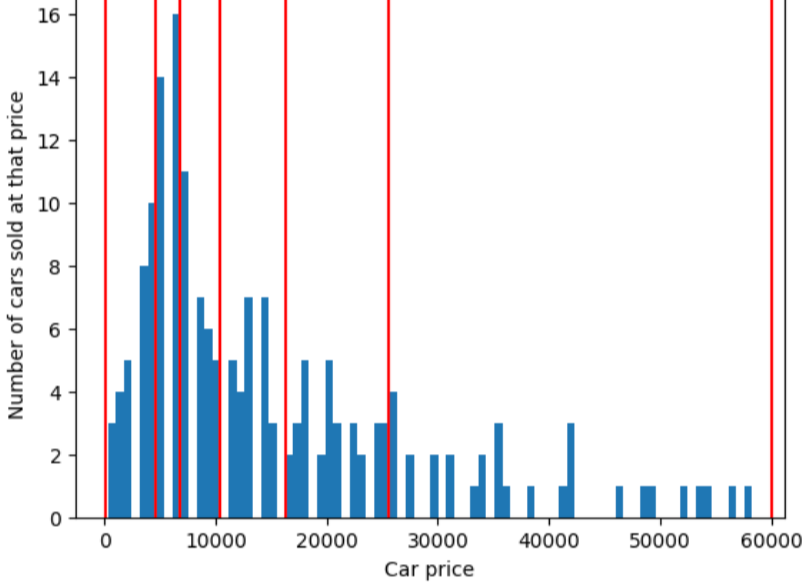

## Categorical Data

The term dimension is a synonym for the number of elements in a feature vector. Some categorical features are low dimensional. For example:

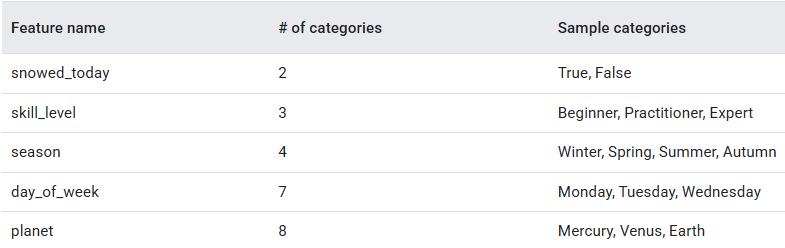

`When a categorical feature has a low number of possible categories, you can encode it as a vocabulary.` With a vocabulary encoding, the model treats each possible categorical value as a separate feature. During training, the model learns different weights for each category.

For example, suppose you are creating a model to predict a car's price based, in part, on a categorical feature named car_color. Perhaps red cars are worth more than green cars. Since manufacturers offer a limited number of exterior colors, car_color is a low-dimensional categorical feature. The following illustration suggests a vocabulary (possible values) for car_color:

In [ ]:
Is the number of unique `modes` considered "low dimensional"?

Is the number of unique cities or UZA considered "high dimensional"?

**Feature crosses**

Feature crosses are created by crossing (taking the Cartesian product of) two or more categorical or bucketed features of the dataset. Like polynomial transforms, feature crosses allow linear models to handle nonlinearities. Feature crosses also encode interactions between features.

For example, consider a leaf dataset with the categorical features:

- edges, containing values smooth, toothed, and lobed
- arrangement, containing values opposite and alternate
Assume the order above is the order of the feature columns in a one-hot representation, so that a leaf with smooth edges and opposite arrangement is represented as {(1, 0, 0), (1, 0)}.

The feature cross, or Cartesian product, of these two features would be:

{Smooth_Opposite, Smooth_Alternate, Toothed_Opposite, Toothed_Alternate, Lobed_Opposite, Lobed_Alternate}

where the value of each term is the product of the base feature values, such that:

- Smooth_Opposite = edges[0] * arrangement[0]
- Smooth_Alternate = edges[0] * arrangement[1]
- Toothed_Opposite = edges[1] * arrangement[0]
- Toothed_Alternate = edges[1] * arrangement[1]
- Lobed_Opposite = edges[2] * arrangement[0]
- Lobed_Alternate = edges[2] * arrangement[1]

For example, if a leaf has a lobed edge and an alternate arrangement, the feature-cross vector will have a value of 1 for Lobed_Alternate, and a value of 0 for all other terms:

`{0, 0, 0, 0, 0, 1}`

In [ ]:
Should we feature-cross mode and service?

Something like "directly operated - bus", "purchased transportation - bus", "directly operated - demand response", "purchased - demand resonse".

## Clustering Advance Course Notes

To cluster your data, you'll follow these steps:

**1. Prepare data.**

you must normalize, scale, and transform feature data before training or fine-tuning a model on that data. In addition, before clustering, check that the prepared data lets you accurately calculate similarity between examples.

**2. Create similarity metric.**

Before a clustering algorithm can group data, it needs to know how similar pairs of examples are. You can quantify the similarity between examples by creating a similarity metric, which requires a careful understanding of your data.

**3. Run clustering algorithm**

A clustering algorithm uses the similarity metric to cluster data. Google course uses k-means.

**4. Interpret results and adjust your clustering.**

Because clustering doesn't produce or include a ground "truth" against which you can verify the output, it's important to check the result against your expectations at both the cluster level and the example level. If the result looks odd or low-quality, experiment with the previous three steps. Continue iterating until the quality of the output meets your needs.

### Normalizing - Log transforms

When a dataset perfectly conforms to a power law distribution, `where data is heavily clumped at the lowest values`, **use a log transform**. See [Log scaling](https://developers.google.com/machine-learning/crash-course/numerical-data/normalization#log_scaling) to review the steps

---

# Knowledge Check

In [1]:
import pandas as pd


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## read in data

In [2]:
transit_metrics = pd.read_parquet(
    f"gs://calitp-analytics-data/data-analyses/ntd/raw_transit_performance_metrics_data.parquet"
)

In [3]:
transit_metrics.head()
# grain: each row is agency, mode, service per year

,agency_name,agency_status,city,mode,service,ntd_id,reporter_type,reporting_module,state,primary_uza_name,year,upt,vrh,vrm,opexp_total,RTPA,_merge
0,City of Porterville (COLT) - Transit Department,Active,Porterville,Demand Response,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2019,13112,2997,43696,572799,Tulare County Association of Governments,both
1,City of Porterville (COLT) - Transit Department,Active,Porterville,Demand Response,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2020,11523,3669,48138,686165,Tulare County Association of Governments,both
2,City of Porterville (COLT) - Transit Department,Active,Porterville,Bus,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2018,635648,50140,700127,3460906,Tulare County Association of Governments,both
3,City of Porterville (COLT) - Transit Department,Active,Porterville,Bus,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2021,145215,21208,244230,2657959,Tulare County Association of Governments,both
4,City of Porterville (COLT) - Transit Department,Active,Porterville,Demand Response,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2021,29380,9565,126604,952031,Tulare County Association of Governments,both


## Test querying NTD data from warehouse
I queried data from `mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_{metric}`


In [4]:
from calitp_data_analysis.sql import get_engine

In [5]:
db_engine = get_engine()

metric_list = [
    # "pmt",
    "upt",
    "vrh",
    "opexp_total"
]

# empty list for appending DFs
df_list = []
with db_engine.connect() as connection:
    for metric in metric_list:
        query = f"""
        SELECT
          ntd_id,
          source_agency,
          agency_status,
          primary_uza_name,
          uza_population,
          uza_area_sq_miles,
          year,
          SUM({metric}) AS total_{metric},
        FROM
          `cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_{metric}`
        WHERE
          source_state = "CA"
          AND year >= 2018
        GROUP BY
          ntd_id,
          source_agency,
          agency_status,
          year,
          primary_uza_name,
          uza_population,
          uza_area_sq_miles
        """
        # create df
        metric = pd.read_sql(query,connection) 
        
        # append df to list
        df_list.append(metric)

# unpack list into separate DFs
ntd_upt, ntd_vrh, ntd_opex = df_list

In [6]:
merge_on_col=["ntd_id", "year","source_agency","agency_status","primary_uza_name","uza_population","uza_area_sq_miles"]
merge_1 = ntd_opex.merge(ntd_upt, on=merge_on_col, how = "inner")

ntd_metrics_merge = merge_1.merge(ntd_vrh, on=merge_on_col, how = "inner")

In [7]:
ntd_metrics_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1614 entries, 0 to 1613
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ntd_id             1524 non-null   object 
 1   source_agency      1614 non-null   object 
 2   agency_status      1614 non-null   object 
 3   primary_uza_name   1614 non-null   object 
 4   uza_population     1614 non-null   int64  
 5   uza_area_sq_miles  1614 non-null   float64
 6   year               1614 non-null   int64  
 7   total_opexp_total  1291 non-null   float64
 8   total_upt          1291 non-null   float64
 9   total_vrh          1291 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 138.7+ KB


## Classify feature columns

In [40]:
display(
    list(transit_metrics.columns),
    list(ntd_metrics_merge.columns)
)

['agency_name',
 'agency_status',
 'city',
 'mode',
 'service',
 'ntd_id',
 'reporter_type',
 'reporting_module',
 'state',
 'primary_uza_name',
 'year',
 'upt',
 'vrh',
 'vrm',
 'opexp_total',
 'RTPA',
 '_merge']

['ntd_id',
 'source_agency',
 'agency_status',
 'primary_uza_name',
 'uza_population',
 'uza_area_sq_miles',
 'year',
 'total_opexp_total',
 'total_upt',
 'total_vrh']

In [10]:
# Feature groups
id_cols = [ # exclude from clustering
    "agency_name",
    "city",
    "ntd_id",
    "state",
    "primary_uza_name",
    "RTPA",
    "reporter_type" # maybe move to categorical
]

categorical_cols =[ # include in clustering
    "mode", # 15 unique values
    "service" # 4
]

numerical_cols = [ # include in clustering
    "upt",
    "vrh",
    "vrm",
    "opexp_total"
]

other_cols = [ # exclude in clustering
    "agency_status"
    "year",
    "reporting_module",
    "_merge"
]

In [39]:
ntd_metrics_merge[['total_opexp_total',
       'total_upt', 'total_vrh',"uza_area_sq_miles","uza_population"]].corr()

,total_opexp_total,total_upt,total_vrh,uza_area_sq_miles,uza_population
total_opexp_total,1.000000,0.931714,0.961704,0.094333,0.048063
total_upt,0.931714,1.000000,0.928159,0.090158,0.056847
total_vrh,0.961704,0.928159,1.000000,0.110404,0.052122
uza_area_sq_miles,0.094333,0.090158,0.110404,1.000000,0.914677
uza_population,0.048063,0.056847,0.052122,0.914677,1.000000


## 2. Mode & Service

### Unique `Mode` sub-categories
Previous research papers categorized mode by have/not have "dedicated right of way"/ "fixed guideway".

In [42]:
display(
    list(transit_metrics["mode"].unique()),
    # list(ntd_metrics_merge["mode"].unique()) # no mode columns in the ntd merge
)

['Demand Response',
 'Bus',
 'Streetcar',
 'Heavy Rail',
 'Demand Response Taxi',
 'Commuter Bus',
 'Hybrid Rail',
 'Commuter Rail',
 'Vanpool',
 'Bus Rapid Transit',
 'Cable Car',
 'Light Rail',
 'Trolleybus',
 'Ferryboats',
 'Monorail / Automated Guideway']

In [14]:
fixed_guideway = [
    "Streetcar",
    "Heavy Rail",
    "Hybrid Rail",
    "Commuter Rail",
    "Cablecar",
    "Light Rail"
]

other =[
    "Trolleybus",
    "Ferryboats"
]

nonfixed_guideway = [
    "Demand Response",
    "Bus",
    "Demand Response Taxi",
    "Commuter Bus",
    "Vanpool",
    "Bus Rapid Transit",
    "Monorail / Automated Guideway"
]

### testing what the dataframe will look like if you separate fixed from nonfixed guideway

In [57]:
fixed_guideway_df = transit_metrics[transit_metrics["mode"].isin(fixed_guideway)]

nonfixed_guideway_df = transit_metrics[transit_metrics["mode"].isin(nonfixed_guideway)]


In [69]:
display(
    fixed_guideway_df.shape, # 97 rows
    nonfixed_guideway_df.shape, # 1973 rows

    fixed_guideway_df.describe(),
    nonfixed_guideway_df.describe(),
    
)

(94, 17)

(1973, 17)

,upt,vrh,vrm,opexp_total
count,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01
mean,1.600509e+07,3.476402e+05,8.894616e+06,1.460777e+08
std,2.423381e+07,5.388976e+05,1.755443e+07,1.753055e+08
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.263242e+06,3.463825e+04,8.330590e+05,2.413429e+07
50%,4.364017e+06,2.006445e+05,3.541112e+06,8.836813e+07
75%,2.317876e+07,3.741710e+05,8.297250e+06,1.880820e+08
max,1.278745e+08,2.669501e+06,8.378382e+07,7.541880e+08


,upt,vrh,vrm,opexp_total
count,1.973000e+03,1.973000e+03,1.973000e+03,1.973000e+03
mean,1.924252e+06,1.039595e+05,1.420036e+06,1.564296e+07
std,1.299111e+07,3.826907e+05,4.385897e+06,7.464036e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.766800e+04,5.613000e+03,6.177500e+04,5.551440e+05
50%,6.782100e+04,1.597000e+04,2.351300e+05,1.681016e+06
75%,3.720890e+05,5.736600e+04,8.782600e+05,6.363781e+06
max,2.609022e+08,6.341989e+06,6.559582e+07,1.355086e+09


### Unique `Service` values

In [74]:
service_pt_do = [
    'Purchased Transportation',
    'Directly Operated',
]

service_other = [
    'Purchased Transportation - Taxi',
    'Purchased Transportation - Transportation Network Company'
]

In [76]:
display(
    fixed_guideway_df["service"].value_counts(),
    nonfixed_guideway_df["service"].value_counts(),
)

Directly Operated           65
Purchased Transportation    29
Name: service, dtype: int64

Purchased Transportation                                     1445
Directly Operated                                             440
Purchased Transportation - Taxi                                74
Purchased Transportation - Transportation Network Company      14
Name: service, dtype: int64

In [79]:
# Which agneices have these other service types?
nonfixed_guideway_df[nonfixed_guideway_df["service"].isin(service_other)]["agency_name"].unique()


array(['City of Modesto (MAX)', 'Paratransit, Inc.',
       'Riverside Transit Agency (RTA)',
       'Sacramento Regional Transit District',
       'San Joaquin Regional Transit District (RTD)',
       'Santa Clara Valley Transportation Authority (VTA)',
       'Access Services (AS)',
       'City of Artesia - Transportation Division',
       'City of Bell - Community Services Department',
       'City of Carson - Transportation Services Division',
       'City of Claremont - Community Services/ Transit Services',
       'City of Cudahy (COC)', 'City of Escalon - Transit Services',
       'City of Huntington Park (HPCA) - Fixed Route Transportation/ Public Works',
       'City of Los Angeles (LADOT) - City of Los Angeles Department of Transportation',
       'City of Montebello (MBL) - Transportation',
       'City of Santa Monica (BBB) - Department of Transportation',
       'City of South Gate - Transportation Department',
       'City of Torrance (TTS) - Transit Department',
       

**RE: what to do with service columns**

- The majority of rows are either Purchased Transportation or Directly Operated. close to a binary response so i think one-hot encode would be the best option.
- Maybe consider removing the PT taxi and PT transportation netwok since there is a low count of rows

## 3. "Flattening" data
If we group by only Agency (flattening, fewer rows), how do we aggregate the other classification variables before we normalize them? Is adding sufficient? Do we need to average any?

In [47]:
# agg the numerical row, end with each row being an agency
group_id_cols = transit_metrics.groupby(id_cols).agg(
    {col: "sum" for col in numerical_cols} 
).reset_index()

# agg the numerical row, end with each row being a uniqu agency/mode/service
group_id_mode_service = transit_metrics.groupby(id_cols+["mode","service"]).agg(
    {col: "sum" for col in numerical_cols} 
).reset_index()

# agg the numerical row, end with each row being an agency
group_cat_cols = transit_metrics.groupby(categorical_cols).agg(
    {col: "sum" for col in numerical_cols} 
).reset_index()

In [49]:
# double checking aggregation works
(transit_metrics[transit_metrics["ntd_id"]=="90211"]["opexp_total"].sum() == group_id_cols[group_id_cols["ntd_id"]=="90211"]["opexp_total"].sum(),
transit_metrics[transit_metrics["mode"]=="Bus"]["opexp_total"].sum() == group_cat_cols[group_cat_cols["mode"]=="Bus"]["opexp_total"].sum())

(True, True)

In [64]:
display("group_id",
    group_id_cols.shape,
    #group_id_cols["service"].value_counts(),  
    group_id_cols.head(),
    "group_id_mode_service",
    group_id_mode_service.shape,
    group_id_mode_service["service"].value_counts(),
    group_id_mode_service.head()
    )

'group_id'

(168, 11)

,agency_name,city,ntd_id,state,primary_uza_name,RTPA,reporter_type,upt,vrh,vrm,opexp_total
0,Access Services (AS),El Monte,90157,CA,"Los Angeles--Long Beach--Anaheim, CA",Southern California Association of Governments,Full Reporter,21100712,11073631,195345317,992266445
1,Alameda-Contra Costa Transit District,Oakland,90014,CA,"San Francisco--Oakland, CA",Metropolitan Transportation Commission,Full Reporter,238095061,12968803,140963319,2864051248
2,Altamont Corridor Express (ACE),Stockton,90182,CA,"Stockton, CA",San Joaquin Council of Governments,Full Reporter,4923384,141171,5573755,143295615
3,Anaheim Transportation Network (ATN),Anaheim,90211,CA,"Los Angeles--Long Beach--Anaheim, CA",Southern California Association of Governments,Full Reporter,40740395,976178,6528424,82415962
4,Antelope Valley Transit Authority (AVTA),Lancaster,90121,CA,"Palmdale--Lancaster, CA",Southern California Association of Governments,Full Reporter,10230960,1222451,20620573,166805222


'group_id_mode_service'

(412, 13)

Purchased Transportation                                     286
Directly Operated                                             98
Purchased Transportation - Taxi                               23
Purchased Transportation - Transportation Network Company      5
Name: service, dtype: int64

,agency_name,city,ntd_id,state,primary_uza_name,RTPA,reporter_type,mode,service,upt,vrh,vrm,opexp_total
0,Access Services (AS),El Monte,90157,CA,"Los Angeles--Long Beach--Anaheim, CA",Southern California Association of Governments,Full Reporter,Demand Response,Purchased Transportation,12734871,7976350,126080433,620608509
1,Access Services (AS),El Monte,90157,CA,"Los Angeles--Long Beach--Anaheim, CA",Southern California Association of Governments,Full Reporter,Demand Response,Purchased Transportation - Taxi,3960167,1450278,32927793,213127543
2,Access Services (AS),El Monte,90157,CA,"Los Angeles--Long Beach--Anaheim, CA",Southern California Association of Governments,Full Reporter,Demand Response Taxi,Purchased Transportation,4405674,1647003,36337091,158530393
3,Alameda-Contra Costa Transit District,Oakland,90014,CA,"San Francisco--Oakland, CA",Metropolitan Transportation Commission,Full Reporter,Bus,Directly Operated,215515514,10283913,103547022,2438528359
4,Alameda-Contra Costa Transit District,Oakland,90014,CA,"San Francisco--Oakland, CA",Metropolitan Transportation Commission,Full Reporter,Bus,Purchased Transportation,1124216,155406,2552511,18759885


In [20]:
display("group_cat",
    group_cat.shape,
    group_cat.head()
)

'group_cat'

(25, 6)

,mode,service,upt,vrh,vrm,opexp_total
0,Bus,Directly Operated,2952883383,109698885,1187304414,21064786925
1,Bus,Purchased Transportation,636746541,45722527,581552826,5000145202
2,Bus Rapid Transit,Directly Operated,40599424,828979,11343877,251967151
3,Cable Car,Directly Operated,21089173,551837,1139285,373274268
4,Commuter Bus,Directly Operated,11604823,769809,16510747,195171589


### compared to `ntd_metrics_merge`

In [21]:
ntd_metrics_merge.head()

,ntd_id,source_agency,agency_status,primary_uza_name,uza_population,uza_area_sq_miles,year,total_opexp_total,total_upt,total_vrh
0,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2022,3945984.0,260879.0,41460.0
1,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2023,NaN,NaN,NaN
2,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2019,4014118.0,635559.0,52834.0
3,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2021,3609990.0,174595.0,30773.0
4,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2020,4212765.0,522056.0,47356.0


In [50]:
group_id_cols[group_id_cols["ntd_id"]=="90211"]["opexp_total"].sum() == ntd_metrics_merge[ntd_metrics_merge["ntd_id"]=="90211"]["total_opexp_total"].sum()

True

For an aggregated dataset, we can use the queried ntd data

In [51]:
merge_group = ntd_metrics_merge.groupby(
    ["ntd_id","source_agency","primary_uza_name","uza_population","uza_area_sq_miles"]
).agg({
    "total_opexp_total":"sum",
    "total_upt":"sum",
    "total_vrh":"sum"
}).reset_index()

In [52]:
merge_group.head()

,ntd_id,source_agency,primary_uza_name,uza_population,uza_area_sq_miles,total_opexp_total,total_upt,total_vrh
0,90003,San Francisco Bay Area Rapid Transit District ...,"San Francisco--Oakland, CA",3515933,513.80,4.109168e+09,455096497.0,13481404.0
1,90004,Golden Empire Transit District (GET),"Bakersfield, CA",570235,132.12,1.938957e+08,27369380.0,1871722.0
2,90006,Santa Cruz Metropolitan Transit District (SCMTD),"Santa Cruz, CA",169038,60.45,2.828370e+08,20980309.0,1318828.0
3,90007,City of Modesto (MAX),"Modesto, CA",357301,70.38,7.735015e+07,8170544.0,809165.0
4,90008,City of Santa Monica (BBB) - Department of Tra...,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,4.715525e+08,55239107.0,2879128.0


In [61]:
group_id_cols[group_id_cols["ntd_id"]=="90211"]["opexp_total"].sum() == merge_group[merge_group["ntd_id"]=="90211"]["total_opexp_total"].sum()

True

**This establishes we can aggregate up to just agecny level data.**

# Are there ways to get more interactive/easy-to-read visualizations?
If it takes significant time, break this one out

In [81]:
import plotly.express as px

In [84]:
group_id_mode_service.columns

Index(['agency_name', 'city', 'ntd_id', 'state', 'primary_uza_name', 'RTPA',
       'reporter_type', 'mode', 'service', 'upt', 'vrh', 'vrm', 'opexp_total'],
      dtype='object')

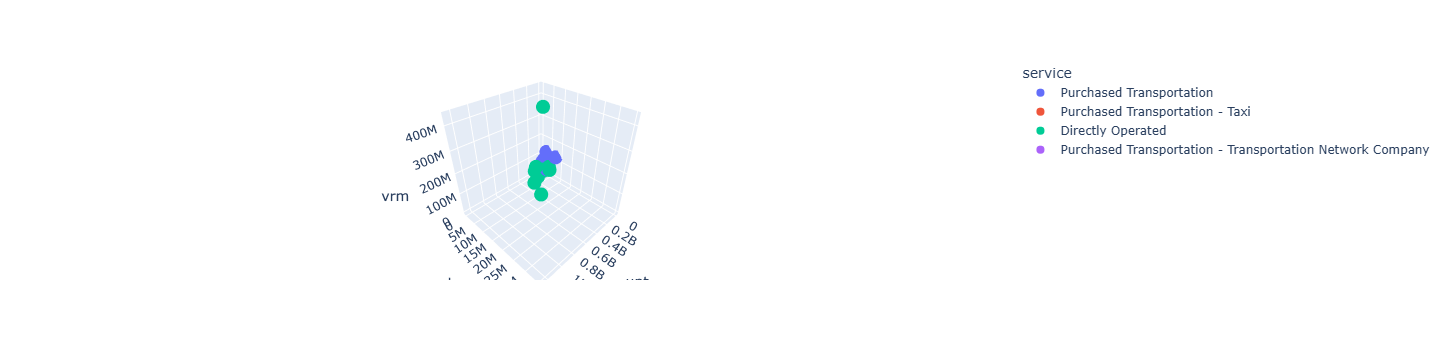

In [85]:
#@title Plot three features in 3D by entering their names and running this cell

x_axis_data = 'upt'  
y_axis_data = 'vrh'  
z_axis_data = 'vrm'  

px.scatter_3d(
    group_id_mode_service,
    x=x_axis_data,
    y=y_axis_data,
    z=z_axis_data,
    color='service',
).show()